# Airline Passenger Satisfaction — Improved Notebook (Multi-Model)

This notebook reproduces and extends the university project by training multiple models on the Kaggle dataset:
- Decision Tree (with & without SelectKBest)
- K-Nearest Neighbors (KNN)
- Naïve Bayes (Gaussian, Multinomial, Bernoulli)
- Support Vector Machines (Linear / RBF / Polynomial)

**Dataset location expected:** `./datasets/train.csv` and `./datasets/test.csv` (relative to this notebook).

**Key improvements vs the original project:**
- Correct target encoding with exact string matching (no accidental leakage).
- Consistent preprocessing (label encoding for categoricals, MinMax scaling for numeric features when needed).
- Clear CV curves and test-set evaluations.
- Unified summary table across all models.


In [1]:

# Imports & constants
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC

RANDOM_STATE = 42
DATA_DIR = "./datasets"
KBEST_K = 15  # You can change this
plt.rcParams['figure.figsize'] = (6, 4)


In [2]:

# Load and combine CSVs
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")
assert os.path.exists(train_path), f"Missing file: {train_path}"
assert os.path.exists(test_path),  f"Missing file: {test_path}"

df_raw = pd.concat([pd.read_csv(train_path), pd.read_csv(test_path)], ignore_index=True)
df_raw.head()


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [3]:

# Cleaning utilities
def basic_clean(df):
    df = df.copy()
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]
    # Drop ID-like columns if present
    for c in ["id", "ID", "Id", "Unnamed:_0", "Unnamed:_0.1"]:
        if c in df.columns:
            df.drop(columns=[c], inplace=True, errors="ignore")
    # Locate target
    target_col = None
    for c in ["satisfaction", "Satisfaction"]:
        if c in df.columns:
            target_col = c
            break
    if target_col is None:
        raise ValueError("Target column 'satisfaction' not found.")

    # Fill arrival delay with mean, convert numerics
    for c in ["Arrival_Delay_in_Minutes", "Arrival_Delay", "Arrival_Delay_in_Minute"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            df[c] = df[c].fillna(df[c].mean())
            break

    # Categorical mode fill
    for c in df.select_dtypes(include=["object"]).columns:
        df[c] = df[c].fillna(df[c].mode().iloc[0])

    # Numeric coercion
    for c in ["Flight_Distance", "Departure_Delay_in_Minutes", "Arrival_Delay_in_Minutes"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
            df[c] = df[c].fillna(df[c].mean())

    return df, target_col

df, target_col = basic_clean(df_raw)
df.head()


,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,...,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:

# IQR outlier removal
def remove_outliers_iqr(df, numeric_cols):
    clean = df.copy()
    mask = np.ones(len(clean), dtype=bool)
    for col in numeric_cols:
        if col not in clean.columns:
            continue
        q1 = clean[col].quantile(0.25)
        q3 = clean[col].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        mask &= (clean[col] >= low) & (clean[col] <= high)
    removed = (~mask).sum()
    return clean.loc[mask].reset_index(drop=True), removed

numeric_for_iqr = [c for c in ["Flight_Distance", "Departure_Delay_in_Minutes", "Arrival_Delay_in_Minutes"] if c in df.columns]
df_iqr, removed = remove_outliers_iqr(df, numeric_for_iqr)
print("Rows removed via IQR:", removed, "Remaining:", df_iqr.shape[0])


Rows removed via IQR: 23193 Remaining: 106687


In [5]:

# Build preprocessed matrices with exact target mapping
def build_preprocessed(df, target_col, use_kbest=True, k_features=15):
    X = df.drop(columns=[target_col]).copy()
    y_text = df[target_col].copy()

    # Exact target mapping
    labels = (
        y_text.astype(str).str.strip().str.lower()
              .map({"satisfied": 1, "neutral or dissatisfied": 0})
    )
    if labels.isna().any():
        labels = (
            y_text.astype(str).str.strip().str.lower()
                  .replace({
                      "neutral or dissatisfied ": "neutral or dissatisfied",
                      "neutral_or_dissatisfied": "neutral or dissatisfied",
                      "neutral/dissatisfied": "neutral or dissatisfied",
                      "dissatisfied": "neutral or dissatisfied"
                  })
                  .map({"satisfied": 1, "neutral or dissatisfied": 0})
        )
    assert not labels.isna().any(), f"Unmapped labels exist: {y_text.unique()}"
    y = labels.values

    # Detect columns
    cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
    num_cols = [c for c in X.columns if c not in cat_cols]

    # Label encode categoricals
    for c in cat_cols:
        le = LabelEncoder()
        X[c] = le.fit_transform(X[c].astype(str))

    # Scale numeric to [0,1] for chi2
    scaler = MinMaxScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])

    if use_kbest:
        selector = SelectKBest(score_func=chi2, k=min(k_features, X.shape[1]))
        X = selector.fit_transform(X, y)

    return X, y

Xk, yk = build_preprocessed(df_iqr, target_col, use_kbest=True,  k_features=KBEST_K)
Xw, yw = build_preprocessed(df_iqr, target_col, use_kbest=False)
print("With KBest:", Xk.shape, "Without KBest:", Xw.shape)


With KBest: (106687, 15) Without KBest: (106687, 22)


In [6]:

# Holdout split
Xk_tr, Xk_te, yk_tr, yk_te = train_test_split(Xk, yk, test_size=0.2, stratify=yk, random_state=RANDOM_STATE)
Xw_tr, Xw_te, yw_tr, yw_te = train_test_split(Xw, yw, test_size=0.2, stratify=yw, random_state=RANDOM_STATE)

print("Class balance (with KBest):", pd.Series(yk_tr).value_counts().to_dict())


Class balance (with KBest): {0: 47670, 1: 37679}


In [7]:

# Evaluation helpers
def eval_and_plots(clf, X_train, y_train, X_test, y_test, title="Model"):
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    auc = None
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_proba)
    elif hasattr(clf, "decision_function"):
        y_score = clf.decision_function(X_test)
        auc = roc_auc_score(y_test, y_score)
    else:
        auc = np.nan

    print(f"{title} — Test Metrics")
    print(f"Accuracy: {acc:.4f}  Precision(macro): {prec:.4f}  Recall(macro): {rec:.4f}  F1(macro): {f1:.4f}  AUC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{title} — Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['Dissatisfied', 'Satisfied'], rotation=45)
    plt.yticks(ticks, ['Dissatisfied', 'Satisfied'])
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()

    # ROC
    try:
        RocCurveDisplay.from_estimator(clf, X_test, y_test)
        plt.title(f"{title} — ROC Curve"); plt.tight_layout(); plt.show()
    except Exception:
        pass

    return acc, prec, rec, f1, auc


## Decision Tree — With and Without KBest

/media/backup/faizan/software/miniforge3/envs/biopy/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[DT + KBest] Best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16} Best CV acc: 0.9342
[DT (No KBest)] Best params: {'max_depth': 18, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16} Best CV acc: 0.9371
Decision Tree (KBest) — Test Metrics
Accuracy: 0.9283  Precision(macro): 0.9288  Recall(macro): 0.9256  F1(macro): 0.9270  AUC: 0.9749


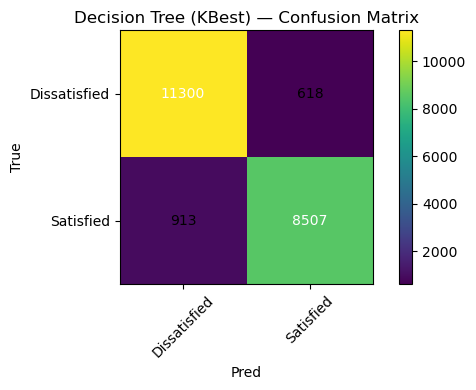

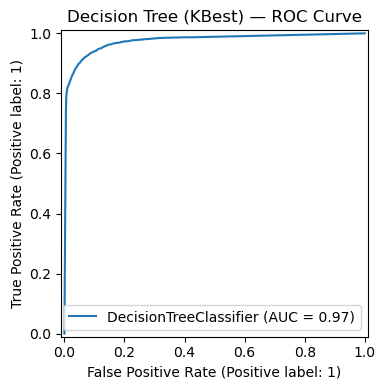

Decision Tree (No KBest) — Test Metrics
Accuracy: 0.9393  Precision(macro): 0.9400  Recall(macro): 0.9368  F1(macro): 0.9382  AUC: 0.9767


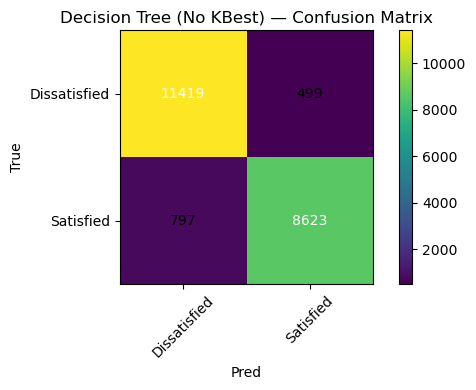

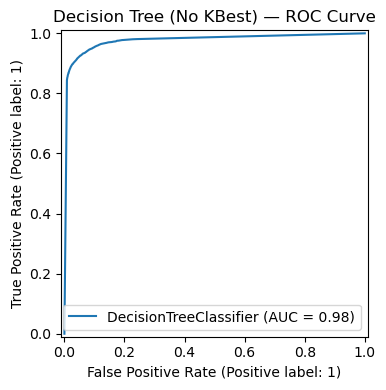

In [8]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Grid around reported sweet spot
param_grid_dt_k = {
    "max_depth": [10, 12, 15, 18],
    "max_features": ["sqrt"],
    "min_samples_leaf": [2, 4, 8],
    "min_samples_split": [8, 16, 24],
}
param_grid_dt_w = {
    "max_depth": [10, 12, 15, 18],
    "max_features": ["sqrt"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [8, 16, 24],
}

def run_gs_dt(Xtr, ytr, grid, tag):
    gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE), grid,
                      scoring="accuracy", cv=cv, n_jobs=-1, refit=True, verbose=0)
    gs.fit(Xtr, ytr)
    print(f"[{tag}] Best params:", gs.best_params_, "Best CV acc:", round(gs.best_score_,4))
    return gs.best_estimator_

dt_kbest = run_gs_dt(Xk_tr, yk_tr, param_grid_dt_k, "DT + KBest")
dt_nokb  = run_gs_dt(Xw_tr, yw_tr, param_grid_dt_w, "DT (No KBest)")

dt_k_metrics = eval_and_plots(dt_kbest, Xk_tr, yk_tr, Xk_te, yk_te, title="Decision Tree (KBest)")
dt_w_metrics = eval_and_plots(dt_nokb, Xw_tr, yw_tr, Xw_te, yw_te, title="Decision Tree (No KBest)")


## K-Nearest Neighbors (KNN)

[KNN] Best params: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'} Best CV acc: 0.9359
KNN (KBest) — Test Metrics
Accuracy: 0.9367  Precision(macro): 0.9389  Recall(macro): 0.9331  F1(macro): 0.9355  AUC: 0.9805


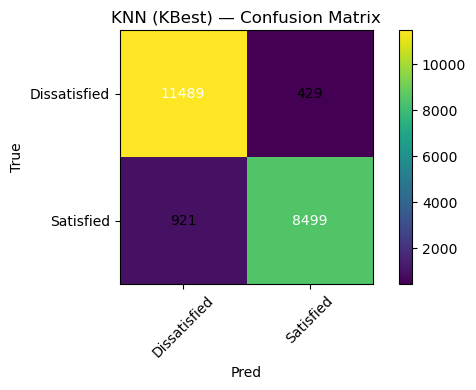

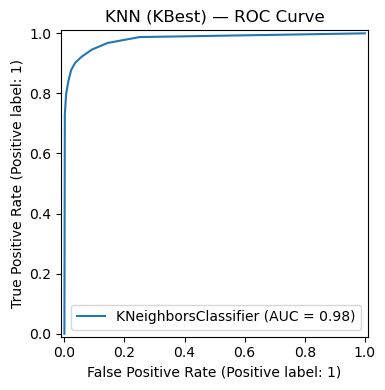

In [9]:

# We'll use the KBest features variant for KNN (consistent with report)
param_grid_knn = {
    "n_neighbors": list(range(3, 12, 2)),  # 3,5,7,9,11
    "weights": ["uniform", "distance"],
    "p": [1, 2],  # Manhattan or Euclidean
}
knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring="accuracy", cv=cv, n_jobs=-1, refit=True)
knn.fit(Xk_tr, yk_tr)
print("[KNN] Best params:", knn.best_params_, "Best CV acc:", round(knn.best_score_,4))
knn_metrics = eval_and_plots(knn.best_estimator_, Xk_tr, yk_tr, Xk_te, yk_te, title="KNN (KBest)")


## Naïve Bayes

GaussianNB — Test Metrics
Accuracy: 0.8648  Precision(macro): 0.8648  Recall(macro): 0.8604  F1(macro): 0.8621  AUC: 0.9227


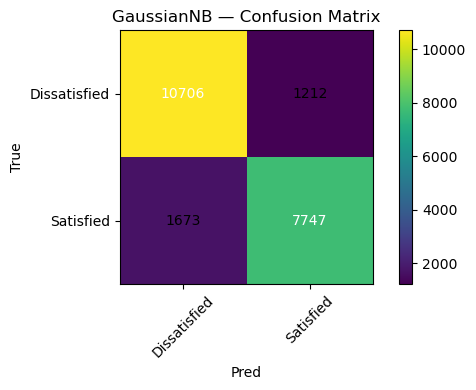

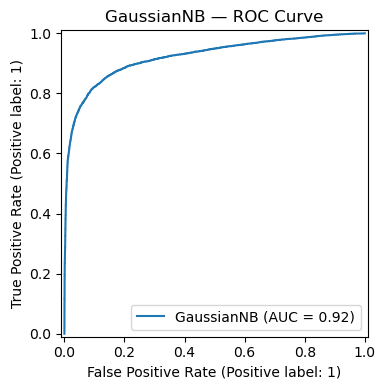

MultinomialNB — Test Metrics
Accuracy: 0.8002  Precision(macro): 0.7980  Recall(macro): 0.7958  F1(macro): 0.7967  AUC: 0.8806


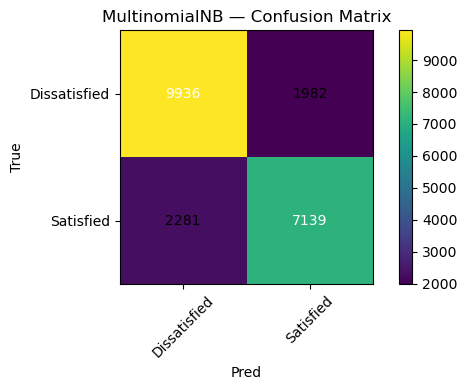

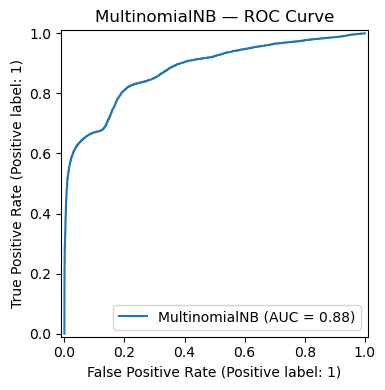

BernoulliNB — Test Metrics
Accuracy: 0.7849  Precision(macro): 0.7819  Recall(macro): 0.7823  F1(macro): 0.7821  AUC: 0.8612


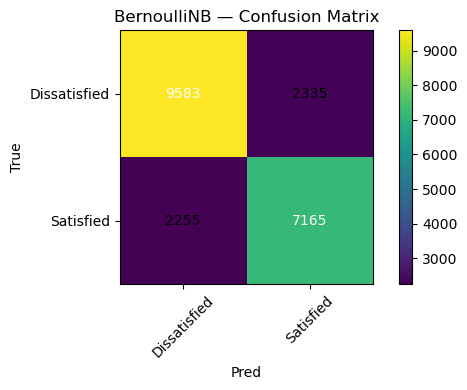

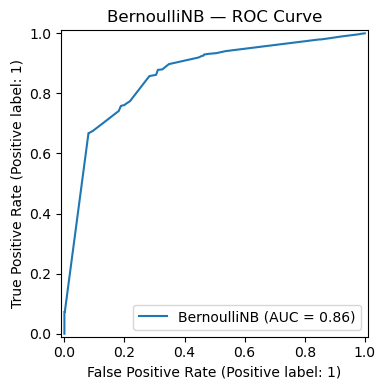

In [10]:

# Evaluate Gaussian, Multinomial, and Bernoulli with KBest features
def eval_nb(model, name):
    model.fit(Xk_tr, yk_tr)
    return eval_and_plots(model, Xk_tr, yk_tr, Xk_te, yk_te, title=name)

nb_gauss = eval_nb(GaussianNB(), "GaussianNB")
# Multinomial/Bernoulli require non-negative counts-like features; KBest+MinMax should be ok but not ideal
nb_multi = eval_nb(MultinomialNB(), "MultinomialNB")
nb_bern  = eval_nb(BernoulliNB(), "BernoulliNB")


## Support Vector Machines (SVM)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
[LinearSVC] Best params: {'C': 1}
LinearSVC — Test Metrics
Accuracy: 0.8686  Precision(macro): 0.8686  Recall(macro): 0.8643  F1(macro): 0.8661  AUC: 0.9201


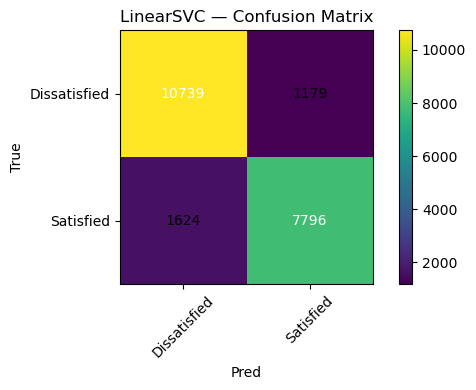

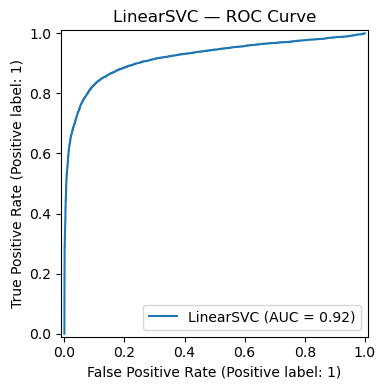

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 9483
max_resources_: 85349
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 12
n_resources: 9483
Fitting 10 folds for each of 12 candidates, totalling 120 fits
----------
iter: 1
n_candidates: 4
n_resources: 28449
Fitting 10 folds for each of 4 candidates, totalling 40 fits
----------
iter: 2
n_candidates: 2
n_resources: 85347
Fitting 10 folds for each of 2 candidates, totalling 20 fits
[SVM RBF] Best params: {'C': 100, 'gamma': 'scale'}
SVM (RBF) — Halving — Test Metrics
Accuracy: 0.9546  Precision(macro): 0.9557  Recall(macro): 0.9523  F1(macro): 0.9538  AUC: 0.9896


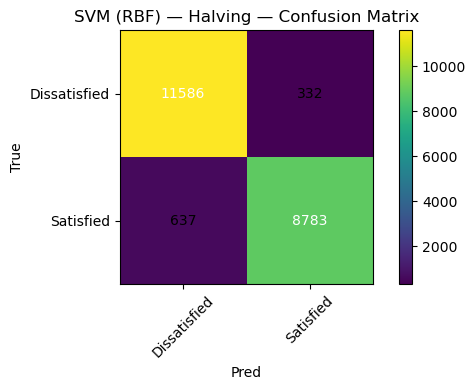

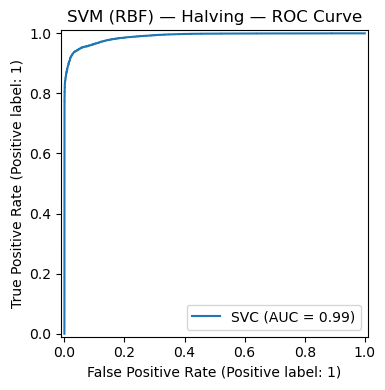

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[RBF Approx] Best params: {'rbfsampler__gamma': 0.001, 'sgdclassifier__alpha': 1e-05}
RBF (Approx via RBFSampler + SGD) — Test Metrics
Accuracy: 0.8593  Precision(macro): 0.8569  Recall(macro): 0.8591  F1(macro): 0.8578  AUC: 0.9204


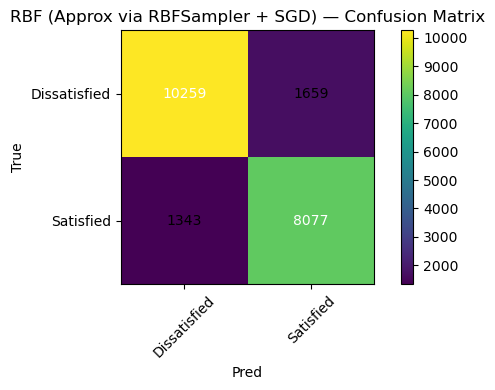

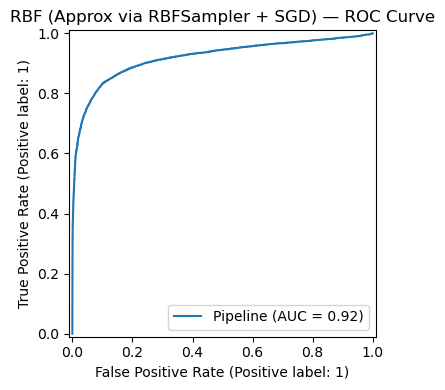

In [11]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

try:
    cv
except NameError:
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def downcast_float32(X):
    return X.astype(np.float32, copy=False)

Xk_tr = downcast_float32(Xk_tr)
Xk_te = downcast_float32(Xk_te)

lin_search = GridSearchCV(
    LinearSVC(dual="auto", random_state=RANDOM_STATE),
    {"C": [0.1, 1, 10, 100]},
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)
lin_search.fit(Xk_tr, yk_tr)
print("[LinearSVC] Best params:", lin_search.best_params_)
svm_lin_metrics = eval_and_plots(lin_search.best_estimator_, Xk_tr, yk_tr, Xk_te, yk_te, title="LinearSVC")

rbf_search = HalvingGridSearchCV(
    SVC(kernel="rbf", probability=False, random_state=RANDOM_STATE, cache_size=2000),
    {"C": [0.1, 1, 10, 100], "gamma": ["scale", 1e-3, 1e-4]},
    factor=3,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)
rbf_search.fit(Xk_tr, yk_tr)
print("[SVM RBF] Best params:", rbf_search.best_params_)
svm_rbf_metrics = eval_and_plots(rbf_search.best_estimator_, Xk_tr, yk_tr, Xk_te, yk_te, title="SVM (RBF) — Halving")


# # Not doing poly because of resources constraints.

# poly_search = HalvingGridSearchCV(
#     SVC(kernel="poly", probability=False, random_state=RANDOM_STATE, cache_size=2000),
#     {"C": [0.1, 1, 10, 100], "degree": [2, 3]},
#     factor=3,
#     scoring="f1_macro",
#     cv=cv,
#     n_jobs=-1,
#     refit=True,
#     verbose=1
# )
# poly_search.fit(Xk_tr, yk_tr)
# print("[SVM Poly] Best params:", poly_search.best_params_)
# svm_poly_metrics = eval_and_plots(poly_search.best_estimator_, Xk_tr, yk_tr, Xk_te, yk_te, title="SVM (Poly) — Halving")

rbf_approx_pipe = make_pipeline(
    RBFSampler(gamma=1e-3, n_components=1000, random_state=RANDOM_STATE),
    SGDClassifier(loss="hinge", alpha=1e-4, max_iter=2000, tol=1e-3, random_state=RANDOM_STATE)
)

rbf_approx_search = GridSearchCV(
    rbf_approx_pipe,
    {"rbfsampler__gamma": [1e-3, 1e-4], "sgdclassifier__alpha": [1e-5, 1e-4, 1e-3]},
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=1
)
rbf_approx_search.fit(Xk_tr, yk_tr)
print("[RBF Approx] Best params:", rbf_approx_search.best_params_)
svm_rbf_fast_metrics = eval_and_plots(rbf_approx_search.best_estimator_, Xk_tr, yk_tr, Xk_te, yk_te, title="RBF (Approx via RBFSampler + SGD)")


## Summary Table

In [12]:

# Collate metrics into a single table
def pack(row):
    return dict(Accuracy=row[0], Precision=row[1], Recall=row[2], F1=row[3], AUC=row[4])

results = pd.DataFrame([
    ["Decision Tree (KBest)", *dt_k_metrics],
    ["Decision Tree (No KBest)", *dt_w_metrics],
    ["KNN (KBest)", *knn_metrics],
    ["GaussianNB", *nb_gauss],
    ["MultinomialNB", *nb_multi],
    ["BernoulliNB", *nb_bern],
    ["SVM (Linear)", *svm_lin_metrics],
    ["SVM (RBF)", *svm_rbf_metrics],
    # ["SVM (Poly)", *svm_poly_metrics],
], columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"])

results.style.format({c: "{:.4f}" for c in ["Accuracy","Precision","Recall","F1","AUC"]})


,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree (KBest),0.9283,0.9288,0.9256,0.9270,0.9749
1,Decision Tree (No KBest),0.9393,0.9400,0.9368,0.9382,0.9767
2,KNN (KBest),0.9367,0.9389,0.9331,0.9355,0.9805
3,GaussianNB,0.8648,0.8648,0.8604,0.8621,0.9227
4,MultinomialNB,0.8002,0.7980,0.7958,0.7967,0.8806
5,BernoulliNB,0.7849,0.7819,0.7823,0.7821,0.8612
6,SVM (Linear),0.8686,0.8686,0.8643,0.8661,0.9201
7,SVM (RBF),0.9546,0.9557,0.9523,0.9538,0.9896
